## Memorizing Normality to Detect Anomaly: Memory-augmented Deep Autoencoder for Unsupervised Anomaly Detection 

This notebook contains implementation of https://arxiv.org/abs/1904.02639 and on top the implementation of the paper there are some changes for improvement of accuracy.


In [1]:
import os
import sys
import cv2
import glob 
import torch
import random 
import resource 
import numpy as np
from math import exp
import torch.nn as nn 
from PIL import Image
from models.memae import *
import torch.optim as optim
import matplotlib.pyplot as plt
import torch.nn.functional as F
from torch.autograd import Variable
from torchvision import transforms, utils
from torch.utils.data import Dataset, DataLoader  
 

# Structure Similarity Loss

The L2 loss computes the loss based on the the pixel wise difference of the input and output images. The problem with L2 loss is that it is very sensitive to minute color changes. 

SSIM in contrast to L2 loss works computes loss on a window instead of each pixel location. Hence it is less prone to small reconstruction errors. And it doesn’t only look at the pixel values like L2 loss. Instead it looks at luminance, contrast and structure inside the window.

The structure Similarity loss (SSIM)  is used for the training of Memory Augmented AutoEncoder (MemAE). 

https://arxiv.org/pdf/1511.08861.pdf

In [2]:
def gaussian(window_size, sigma):
    """
    Args:
        window_size: Size of Gaussian window
        sigma: mean for the gaussian

    Returns:
        gauss. a gaussian matrix with mean equal to sigma and size equal to window size 
    """
    gauss = torch.Tensor([exp(-(x - window_size//2)**2/float(2*sigma**2)) for x in range(window_size)])
    return gauss/gauss.sum()

def create_window(window_size, channel):
    """
    Args:
        window_size: Size of Gaussian window
        channel: number of channels in the gaussian filter

    Returns:
        window: Gaussian tensor
    """
    _1D_window = gaussian(window_size, 1.5).unsqueeze(1)
    _2D_window = _1D_window.mm(_1D_window.t()).float().unsqueeze(0).unsqueeze(0)
    window = Variable(_2D_window.expand(channel, 1, window_size, window_size).contiguous())
    return window

def _ssim(img1, img2, window, window_size, channel, size_average = False):
    """
    Args:
        img1: image one to be compared
        img2: image two to be compared
        window: the Gaussian window
        window_size: size of the Gaussian Window
        channel: number of output channels
        size_average: take mean of the final similarity matrix or not

    Returns:
        ssim_map: Structural similarity index of two images
    """
    mu1 = F.conv2d(img1, window, padding = window_size//2, groups = channel)
    mu2 = F.conv2d(img2, window, padding = window_size//2, groups = channel)

    mu1_sq = mu1.pow(2)
    mu2_sq = mu2.pow(2)
    mu1_mu2 = mu1*mu2

    sigma1_sq = F.conv2d(img1*img1, window, padding = window_size//2, groups = channel) - mu1_sq
    sigma2_sq = F.conv2d(img2*img2, window, padding = window_size//2, groups = channel) - mu2_sq
    sigma12 = F.conv2d(img1*img2, window, padding = window_size//2, groups = channel) - mu1_mu2

    C1 = 0.01**2
    C2 = 0.03**2

    ssim_map = ((2*mu1_mu2 + C1)*(2*sigma12 + C2))/((mu1_sq + mu2_sq + C1)*(sigma1_sq + sigma2_sq + C2))

    if size_average and False: 
        return ssim_map.mean()
    else:
        return ssim_map
        return ssim_map.mean(1).mean(1).mean(1)

class SSIM(torch.nn.Module):
    """ 
    Class for SSIM loss 
      
    Attributes: 
        size_average: Take mean of the loss or not 
        window_size: size of similarity window 
    """
    def __init__(self, window_size = 11, size_average = True):
        super(SSIM, self).__init__()
        self.window_size = window_size
        self.size_average = size_average
        self.channel = 1
        self.window = create_window(window_size, self.channel)
         
    def forward(self, img1, img2):
        (_, channel, _, _) = img1.size()

        if channel == self.channel and self.window.data.type() == img1.data.type():
            window = self.window
        else:
            window = create_window(self.window_size, channel)
            
            if img1.is_cuda:
                window = window.cuda(img1.get_device())
            window = window.type_as(img1)
            
            self.window = window
            self.channel = channel

        return _ssim(img1, img2, window, self.window_size, channel, self.size_average)

 

# DataLoader for Memory Autoencoder
The data loader takes the path where images are present and takes start and end index. After loading all the images from the directory we have a list of image paths. the start index represents the index of the list of paths and end index represents the index of the list. we only consider images from start to end.

We make three datasets.

1) Train dataset used for training of the memory autoencoder (good images)

2) Test Good used for validation/testing of the memory autoencoder (good images)

3) Test Bad used for validatoin/ testing of memory autoencoder (bad/defective images)

In [18]:
class MemDataset(Dataset):
    """Memory Auto Encoder Dataset"""

    def __init__(self,root_dir,start,end,train=True):
        """
        Args:
            root_dir : Directory with all the images.
            start : starting index of images to include in this set
            end : ending index of images to include in this set
            train : train or test
        """
        self.transform=transforms.Compose([    transforms.Resize((98,98)), 
                                               transforms.Grayscale(num_output_channels=1),
                                               transforms.ToTensor()
                                           ])
        self.train = train
        self.dataset = glob.glob(root_dir)[start:end] 
       

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        img_name = self.dataset[idx]
        im = np.array(Image.open(img_name))  
        im = Image.fromarray(im) 
        im = self.transform(im)
        return im,im

    
train_good = MemDataset('../defect/datasets/infineon/train_memae/train/*',0,8500)
test_good = MemDataset('../defect/datasets/infineon/train_memae/test_good/*',0,462,False)
test_bad = MemDataset('../defect/datasets/infineon/train_memae/test_bad/*',0,462,False)

print ("Train Good",train_good.__len__(), "\nTest defective", test_bad.__len__(),"\nTest good", test_good.__len__())

train_loader = torch.utils.data.DataLoader(train_good,batch_size=2, shuffle=True,
                                             num_workers=4)
test_loader_bad = torch.utils.data.DataLoader(test_bad,batch_size=2, shuffle=False,
                                             num_workers=4)
test_loader_good = torch.utils.data.DataLoader(test_good,batch_size=2, shuffle=False,
                                             num_workers=4)


Train Good 8491 
Test defective 462 
Test good 462


### Create model instance and load model weights if a trained model is present already

In [19]:
# Create model object with 1000 memory locations
model = MEMAE(1000).cuda()
# Load weights
model.load_state_dict(torch.load("./ckpts/memae_ckpt/ssm_97_3.pt")) 
model.train()


 

MEMAE(
  (encoder): Encoder(
    (conv1): Conv2d(1, 16, kernel_size=(1, 1), stride=(2, 2), padding=(1, 1))
    (bn1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (bn2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (conv3): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (bn3): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (conv4): Conv2d(64, 64, kernel_size=(3, 3), stride=(2, 2))
    (bn4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
  )
  (cosine_similarity): CosineSimilarity()
  (decoder): Decoder(
    (deconv0): ConvTranspose2d(64, 64, kernel_size=(3, 3), stride=(2, 2))
    (bn0): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (deconv1): ConvTranspose2d(64, 32, kerne

## Train Epoch

In [20]:
def plot(inputs,outputs):
    im = inputs.cpu().detach().numpy()[0]
    im = np.transpose(im,(1,2,0)) 
    outputs = outputs.cpu().detach().numpy()[0]  
    outputs[outputs>1]=1
    outputs = np.transpose(outputs,(1,2,0))[:,:,0] 


    plt.imshow(im.reshape(98,98),cmap="gray")#.cpu().detach().numpy().reshape(98,98),cmap="gray")
    plt.show()
    plt.imshow(outputs,cmap="gray")
    plt.show() 

def train(model,dataloader,criteria,optimizer,train=True,step=100):
    """
    Args:
        model: Memory Augmented Auto Encoder
        dataloader: Image dataloader
        criteria: Loss function, L2 or SSIM
        optimizer: the optimizer used for training, default is Adam
        train: train or test set
        step: step after which image will be shown

    Returns:
        losses: A list of losses on all test images
    """
    
    losses = list() 
    if not train:
        model.eval()
    else:
        model.train()
    for i,(im,lab) in enumerate(dataloader): 
        optimizer.zero_grad() 
        outputs = model(im.cuda())  
        #Minimize the similarity difference
        loss =  1-criteria(outputs, lab.cuda()) 
        if not train:
            loss = loss.cpu().detach().numpy()  
            loss = np.sort(loss.reshape(loss.shape[0],-1),-1) 
            error = np.median(loss,-1)*np.median(loss[:,-45:],-1).tolist()
            losses.extend(error)
            
        phase = "Train" if train else "Test" 
        if i%10 == 0 :
            print (phase," Iteration: ",i,"LOSS : ",loss.mean().item())
        if i % step == 0 and not train:
             plot(im,outputs)
            
        if train:
            loss.mean().backward()
            optimizer.step()
    
    return losses



#### The Calculate Acc function takes the lists of losses for good and bad images and finds the optimal threshold that seperates them with best accuracy

In [21]:
def calculate_acc(loss_lists):
    """
    Args:
        loss_lists: list of losses for bad and good test images
    Returns:
        accuracy, thres: Best accuracy and threshold calculated from losses
    """
    neg_np =  (np.array(loss_lists[0]))
    pos_np =  (np.array(loss_lists[1]))
    pos_np *=1000
    neg_np *=1000
    start,end = np.median(pos_np),np.median(neg_np) 
    
    thresholds = np.linspace(0, end, num=1000)
    accuracy = 0
    thres = 0
    print ("Total Positives ",pos_np.shape,"Total Negatives" ,neg_np.shape)
    accs = list()
    defects = list()
    normal = list()
    for threh in thresholds: 
#         threh = n/p.max(pos_np)+0.000001
        current_acc = ((pos_np[pos_np<threh].shape[0])+(neg_np[neg_np>=threh].shape[0])) / (pos_np.shape[0]+neg_np.shape[0])
        accs.append(current_acc)
        defects.append(neg_np[neg_np>=threh].shape)
        normal.append(pos_np[pos_np<threh].shape)
        if accuracy < current_acc:
            accuracy = current_acc
            thres  = threh
    plt.ylabel("True Negative")
    plt.xlabel("Threshold")
    plt.plot(thresholds,accs)
    plt.show()

    
    print ("Positive",(pos_np[pos_np<thres].shape)[0] / pos_np.shape[0],"Anomaly",(neg_np[neg_np>=thres].shape)[0]/neg_np.shape[0], "Distribution")
    return accuracy,thres

Epoch ___________________________________ 1
Test  Iteration:  0 LOSS :  0.011307014152407646


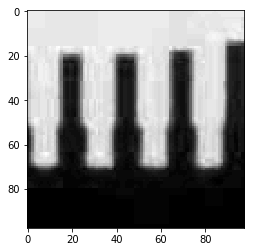

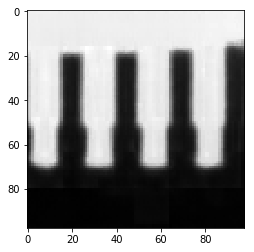

Test  Iteration:  10 LOSS :  0.015017088502645493
Test  Iteration:  20 LOSS :  0.024723578244447708
Test  Iteration:  30 LOSS :  0.018656695261597633
Test  Iteration:  40 LOSS :  0.03582078590989113
Test  Iteration:  50 LOSS :  0.017652694135904312
Test  Iteration:  60 LOSS :  0.01153035368770361
Test  Iteration:  70 LOSS :  0.014177963137626648
Test  Iteration:  80 LOSS :  0.05855768546462059
Test  Iteration:  90 LOSS :  0.012620384804904461
Test  Iteration:  100 LOSS :  0.01451167743653059
Test  Iteration:  110 LOSS :  0.032150547951459885
Test  Iteration:  120 LOSS :  0.01705287955701351
Test  Iteration:  130 LOSS :  0.01758253015577793
Test  Iteration:  140 LOSS :  0.01844138465821743
Test  Iteration:  150 LOSS :  0.020230967551469803
Test  Iteration:  160 LOSS :  0.01143895648419857
Test  Iteration:  170 LOSS :  0.009779428131878376
Test  Iteration:  180 LOSS :  0.012781960889697075
Test  Iteration:  190 LOSS :  0.016638273373246193
Test  Iteration:  200 LOSS :  0.0161404218524694

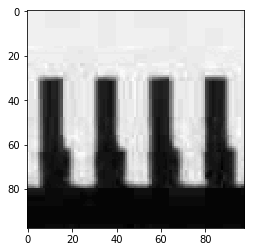

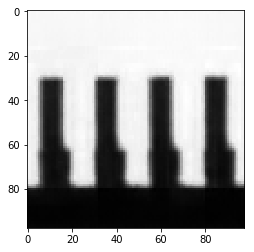

Test  Iteration:  10 LOSS :  0.007891190238296986
Test  Iteration:  20 LOSS :  0.007602002937346697
Test  Iteration:  30 LOSS :  0.007484485395252705
Test  Iteration:  40 LOSS :  0.008349807932972908
Test  Iteration:  50 LOSS :  0.008070189505815506
Test  Iteration:  60 LOSS :  0.008352134376764297
Test  Iteration:  70 LOSS :  0.008093452081084251
Test  Iteration:  80 LOSS :  0.008779752999544144
Test  Iteration:  90 LOSS :  0.007894926704466343
Test  Iteration:  100 LOSS :  0.009501926600933075
Test  Iteration:  110 LOSS :  0.009072838351130486
Test  Iteration:  120 LOSS :  0.00914438720792532
Test  Iteration:  130 LOSS :  0.0077064246870577335
Test  Iteration:  140 LOSS :  0.007723252754658461
Test  Iteration:  150 LOSS :  0.008055356331169605
Test  Iteration:  160 LOSS :  0.008461089804768562
Test  Iteration:  170 LOSS :  0.009096107445657253
Test  Iteration:  180 LOSS :  0.008371660485863686
Test  Iteration:  190 LOSS :  0.007653658743947744
Test  Iteration:  200 LOSS :  0.00925694

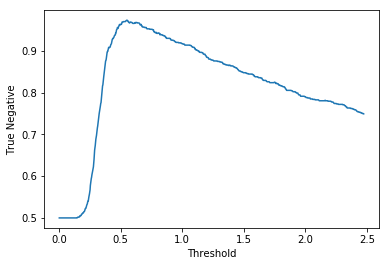

Positive 0.961038961038961 Anomaly 0.9848484848484849 Distribution
ACCURACY:  0.9729437229437229 THRESHOLD:  0.5474180276020456


In [22]:

criteria = SSIM().cuda()
optimizer = optim.Adam(model.parameters(), lr=0.011)
phases = {"train":train_loader,"test":[test_loader_bad,test_loader_good]}
total_epochs = 200
epoch = 0
max_acc = 0

while True:
    epoch+=1
    print ("Epoch ___________________________________",epoch)
    if epoch ==total_epochs:
        break
    for phase in phases:
        loaders = phases[phase]
        if phase == 'train': 
            continue
            train(model,loaders,criteria,optimizer,True,50)
        else:  
            loss_lists = list()
            for loader in loaders:
                losses = train(model,loader,criteria,optimizer,False,1000)
                loss_lists.append(losses)
            acc,thr = calculate_acc(loss_lists)
            print ("ACCURACY: ",acc, "THRESHOLD: ",thr)
#             if max_acc < acc:
#                 torch.save(model.state_dict(),str(acc)+".pt")
#                 max_acc = acc
    break
 
